In [1]:
# Import necessary modules
import scanpy as sc
from image_processing import load_image, normalize_image, load_stardist_model, predict_nuclei

# Set up configurations
dir_base = '/home/sromero/visium_hd_processing/'
img_file = dir_base + 'Visium_HD_Mouse_Small_Intestine_tissue_image.btf'

dir_hd5 = '/home/sromero/visium_hd_processing/Visium_HD_Mouse_Small_Intestine_binned_outputs/binned_outputs/square_002um/'
h5_file = dir_hd5 + 'filtered_feature_bc_matrix.h5'

dir_tissue = dir_hd5 + 'spatial/'
tissue_position_file = dir_tissue+'tissue_positions.parquet'

# Load and process image
print("Loading and processing image...")
img = load_image(img_file)
img = normalize_image(img, min_percentile = 5, max_percentile = 95)

print("Loading pre-trained StarDist model...")
model = load_stardist_model()

print("Predicting nuclei...") # This is crucial
labels, polys = predict_nuclei(model, img, block_size = 4096, prob_thresh = 0.01, nms_thresh = 0.001)

2024-11-15 15:13:54.628875: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-15 15:13:54.632750: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-15 15:13:54.642338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731705234.658600  372665 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731705234.663291  372665 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 15:13:54.680604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Loading and processing image...
Loading pre-trained StarDist model...
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Predicting nuclei...
effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


2024-11-15 15:14:15.506228: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
functional.py (225): The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [15:10<00:00, 21.67s/it]


In [2]:
from data_processing import create_geodataframe, merge_tissue_positions, filter_spatial_overlap, sum_gene_counts

# Create GeoDataFrame
print("Creating GeoDataFrame...")
gdf = create_geodataframe(polys['coord'])

# Optional: Calculate additional nuclei metrics or filter them
# Uncomment and implement these functions if needed
# gdf = calculate_nuclei_metrics(gdf)
# gdf = filter_nuclei(gdf, min_area=10, max_area=1000)

# Display summary of the GeoDataFrame
gdf.head()


Creating GeoDataFrame...


,geometry,id
0,"POLYGON ((2240.695 1130, 2240.044 1131.202, 22...",ID_1
1,"POLYGON ((3917.366 710, 3917.39 710.674, 3917....",ID_2
2,"POLYGON ((3922.438 3616, 3921.838 3617.957, 39...",ID_3
3,"POLYGON ((6652.58 2864, 6651.805 2865.95, 6650...",ID_4
4,"POLYGON ((6457.916 3596, 6457.597 3597.511, 64...",ID_5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6418919..1.081081].


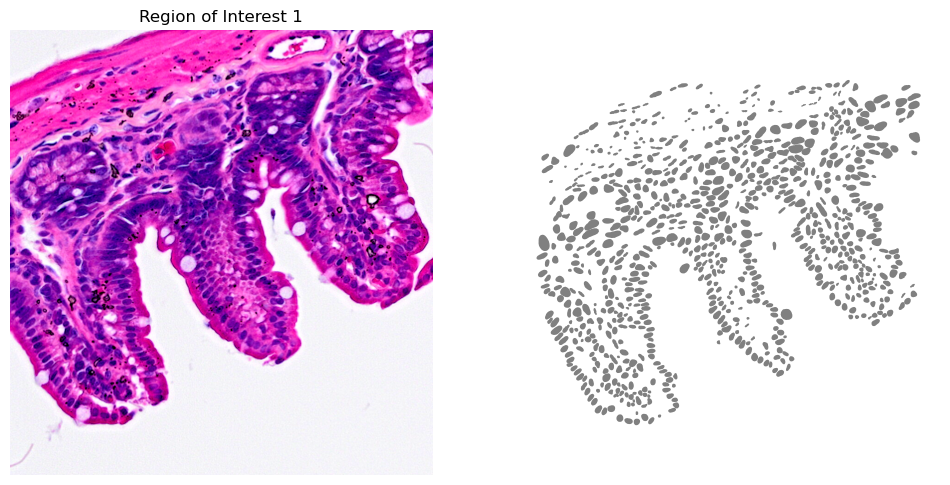

In [40]:
from plotting import plot_mask_and_save_image, plot_gene_and_save_image, plot_clusters_and_save_image
from matplotlib.colors import ListedColormap

# Plot the nuclei segmentation
# bbox=(x min,y min,x max,y max)
bbox=(12844,7700,13760,8664)

# Define a single color cmap
cmap=ListedColormap(['grey'])

# Create Plot
plot_mask_and_save_image(title = "Region of Interest 1", gdf = gdf, bbox = bbox,
                         cmap = cmap,img = img, output_name = dir_base+"image_mask.ROI1.tif")

In [41]:
from clustering import calculate_qc_metrics, filter_and_normalize, perform_clustering

In [42]:
# Process AnnData
print("Reading AnnData...")
adata = sc.read_10x_h5(h5_file)

# Load the Spatial Coordinates
dir_tissue = dir_hd5 + 'spatial/'
tissue_position_file = dir_tissue+'tissue_positions.parquet'

# Uncomment if implementing this function:
# adata = sum_gene_counts(adata)

# Display summary of AnnData object
adata


Reading AnnData...


anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 5479660 × 19059
    var: 'gene_ids', 'feature_types', 'genome'

In [44]:
import pandas as pd
dir_tissue = dir_hd5 + 'spatial/'
tissue_position_file = dir_tissue + 'tissue_positions.parquet'
tissue_position_file2 = '/home/sromero/visium_hd_processing/Visium_HD_Mouse_Small_Intestine_binned_outputs/binned_outputs/square_002um/spatial/tissue_positions.parquet'

# Now read the parquet file
tissue_positions = pd.read_parquet(tissue_position_file, engine='pyarrow')



In [51]:
import importlib
import data_processing
importlib.reload(data_processing)  # Reload it to apply changes




<module 'data_processing' from '/home/sromero/visium_hd_processing/modularized_pipeline/data_processing.py'>

In [53]:
print("Merging tissue positions...")
# Ensure `tissue_positions` is prepared if needed
adata = merge_tissue_positions(adata, tissue_position_file)

Merging tissue positions...


AttributeError: 'str' object has no attribute 'set_index'

In [ ]:
# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(df_tissue_positions['pxl_col_in_fullres'], df_tissue_positions['pxl_row_in_fullres'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)

In [17]:
# Perform quality control and normalization
print("Calculating QC metrics...")
calculate_qc_metrics(adata)

print("Filtering and normalizing...")
# Replace with actual filters as needed
area_mask = adata.obs["area"] > 10  # Example filter
count_mask = adata.obs["total_counts"] > 500  # Example filter
adata = filter_and_normalize(adata, area_mask, count_mask)

# Perform clustering
print("Performing clustering...")
adata = perform_clustering(adata)


Calculating QC metrics...
Filtering and normalizing...


KeyError: 'area'

In [ ]:
# Plot results
print("Plotting segmentation...")
plot_image_with_mask("Nuclei Segmentation", gdf, img, output_name=dir_base+"segmentation.png")

print("Plotting gene expression...")
plot_gene_expression("Gene Expression", gdf, "GeneX", img, adata, output_name=dir_base+"gene_expression.png")

print("Plotting clusters...")
plot_clusters("Clustering", gdf, img, adata, color_by_obs="clusters", output_name=dir_base+"clusters.png")


In [ ]:
# Save results
print("Saving processed data...")
adata.write_h5ad(dir_base + 'processed_data.h5ad')
print("Pipeline complete!")
